# Exploratory Data Analysis (EDA)

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

accounts = pd.read_csv('../data/raw/accounts.csv')
subs = pd.read_csv('../data/raw/subscriptions.csv')
usage = pd.read_csv('../data/raw/feature_usage.csv')
tickets = pd.read_csv('../data/raw/support_tickets.csv')
churn = pd.read_csv('../data/raw/churn_events.csv')

usage['usage_date'] = pd.to_datetime(usage['usage_date'])
accounts['signup_date'] = pd.to_datetime(accounts['signup_date'])

print("Data successfully loaded!")

Data successfully loaded!


# Target variable analysis

C:\Users\90534\AppData\Local\Temp\ipykernel_23336\4149134013.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='churn_flag' , data= accounts , palette='viridis')


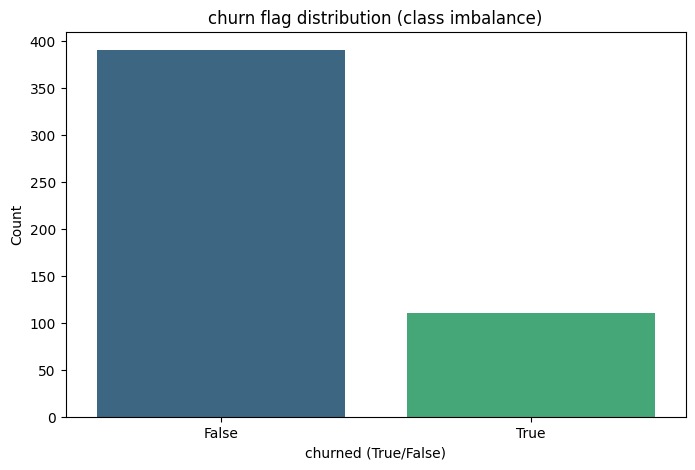

total Accounts : 500
Churn Rate :  22.00%


In [3]:
plt.figure(figsize=(8,5))
sns.countplot(x='churn_flag' , data= accounts , palette='viridis')
plt.title("churn flag distribution (class imbalance)")
plt.xlabel('churned (True/False)')
plt.ylabel('Count')
plt.show()

churn_rate = accounts['churn_flag'].mean() * 100
print(F"total Accounts : {len(accounts)}")
print(f"Churn Rate : {churn_rate: .2f}%")

# Activity Density

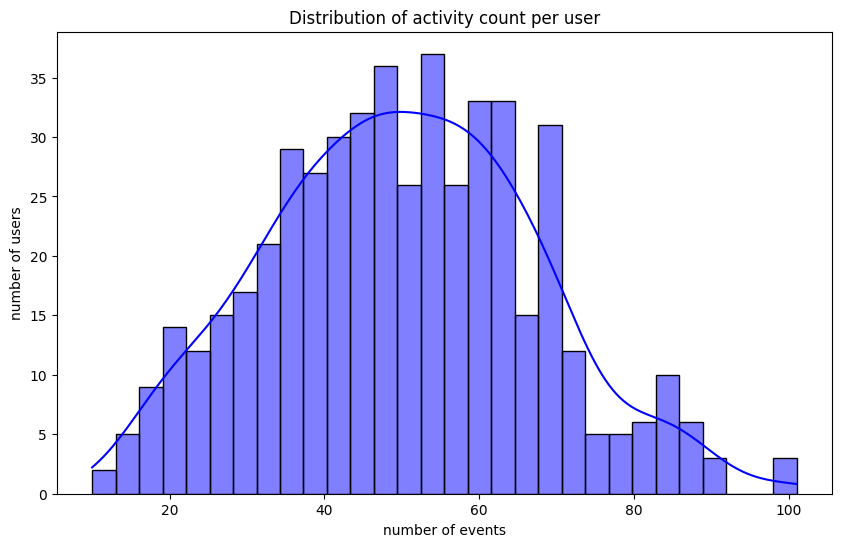

average events per users :  50.00
median events per users : 50.0
standard deviation of events :  17.19


In [4]:
# link usage logs with account ID's via subscriptions
usage_summary = usage.merge(
    subs[['subscription_id' , 'account_id']] , 
    on = 'subscription_id' ,
    how='left'
)

# calculate total event counts per user
user_event_counts = usage_summary.groupby('account_id').size()


plt.figure(figsize=(10,6))
sns.histplot(user_event_counts , bins=30 , kde=True , color='blue')
plt.title('Distribution of activity count per user')
plt.xlabel('number of events')
plt.ylabel('number of users')
plt.show()


print(f"average events per users : {user_event_counts.mean() : .2f}")
print(f"median events per users : {user_event_counts.median()}")
print(f"standard deviation of events : {user_event_counts.std() : .2f}")

# Support & Satisfaction analysis

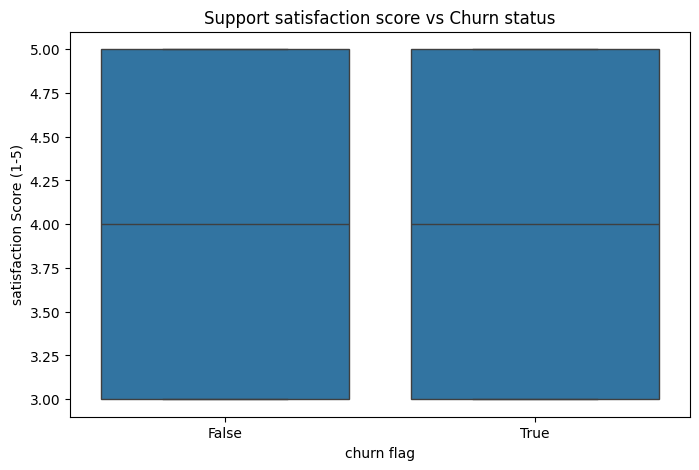

mean satisfaction score by churn status
churn_flag
False    3.972678
True     4.011538
Name: satisfaction_score, dtype: float64


In [5]:
# Merge accounts with tickests to see satisfaction impact on churn
satisfaction_data = accounts.merge(tickets, on='account_id' , how='inner')

plt.figure(figsize=(8,5))
sns.boxplot(x='churn_flag' , y= 'satisfaction_score' , data=satisfaction_data)
plt.title('Support satisfaction score vs Churn status')
plt.xlabel('churn flag')
plt.ylabel('satisfaction Score (1-5)')
plt.show()

print("mean satisfaction score by churn status")
print(satisfaction_data.groupby('churn_flag')['satisfaction_score'].mean())

# Monthly activity trend

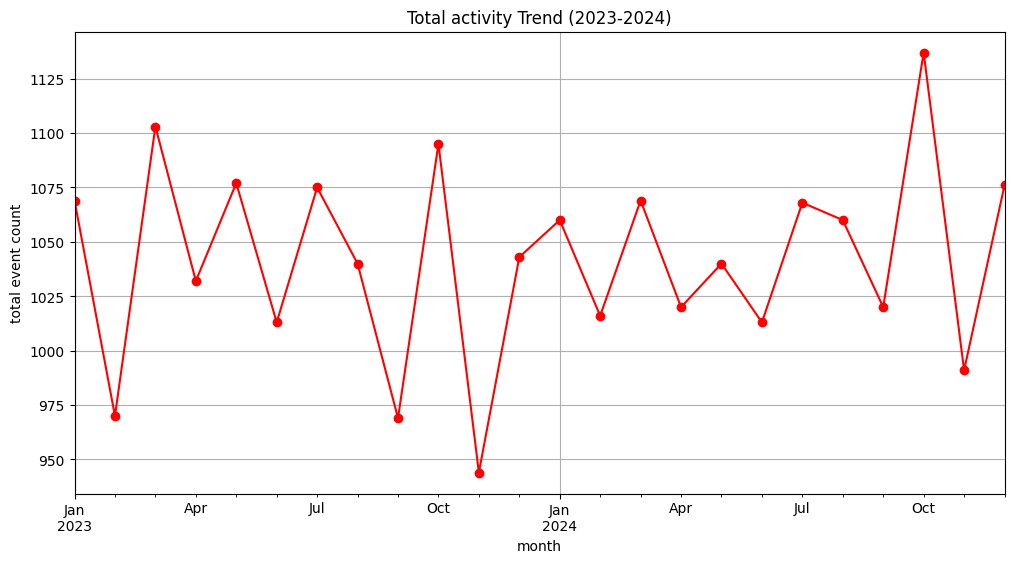

monthly event distribution summary : 
count      24.000000
mean     1041.666667
std        45.662911
min       944.000000
25%      1015.250000
50%      1041.500000
75%      1070.500000
max      1137.000000
dtype: float64


In [6]:
# extract year and month for grouping
usage['usage_month'] = usage['usage_date'].dt.to_period('M')

# calculate total events per month across all users
monthly_events = usage.groupby('usage_month').size()

plt.figure(figsize=(12,6))
monthly_events.plot(kind='line' , marker='o' , color='red')
plt.title('Total activity Trend (2023-2024)')
plt.xlabel('month')
plt.ylabel('total event count')
plt.grid(True)
plt.show()

print("monthly event distribution summary : ")
print(monthly_events.describe())

# user level sparsity analysis

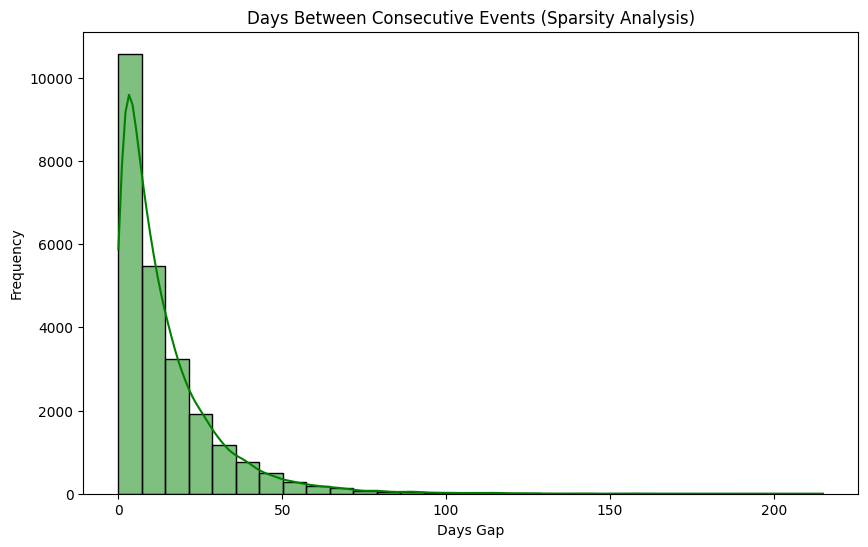

Average gap between user activities: 14.26 days


In [8]:
# sort usage data by user and data
usage_sorted = usage_summary.sort_values(by=['account_id' , 'usage_date'])

# calculate the difference in days beween consecutive uses for each user
usage_sorted['days_since_last_event'] = usage_sorted.groupby("account_id")['usage_date'].diff().dt.days

plt.figure(figsize=(10, 6))
sns.histplot(usage_sorted['days_since_last_event'].dropna(), bins=30, kde=True, color='green')
plt.title('Days Between Consecutive Events (Sparsity Analysis)')
plt.xlabel('Days Gap')
plt.ylabel('Frequency')
plt.show()

# Calculate mean gap between activities
avg_gap = usage_sorted['days_since_last_event'].mean()
print(f"Average gap between user activities: {avg_gap:.2f} days")


# analyzing distribution after generating sysnthetic data

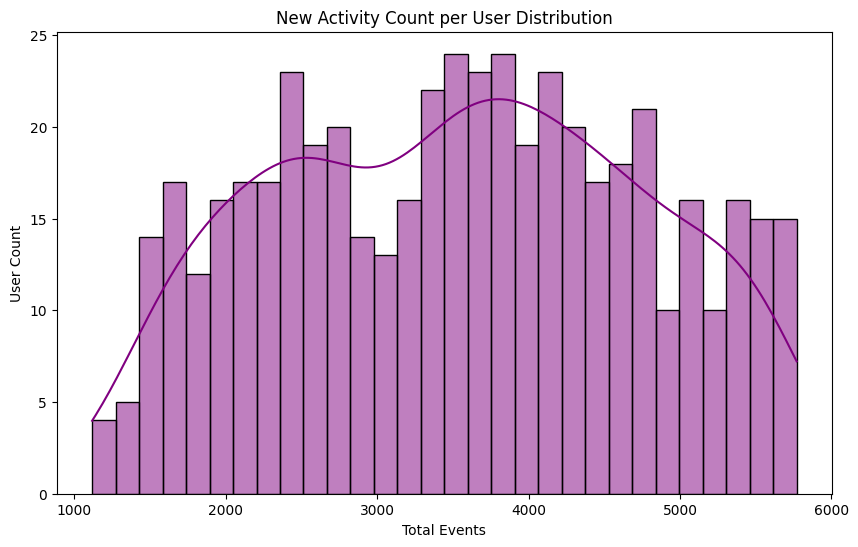

Total Synthetic Events: 1770313
New Avg Events per User: 3540.63


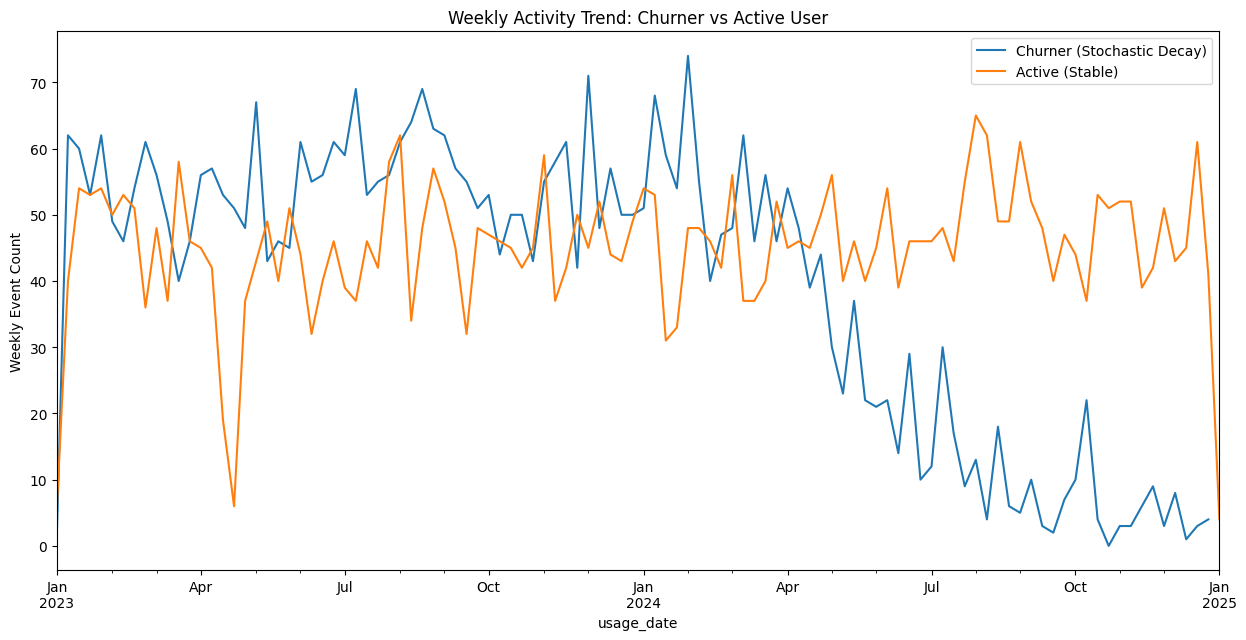

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the new synthetic usage data
usage = pd.read_csv('../data/raw/feature_usage_synthetic.csv')
accounts = pd.read_csv('../data/raw/accounts.csv')

# Convert date
usage['usage_date'] = pd.to_datetime(usage['usage_date'])

# 1. Total Activity Distribution
events_per_user = usage.groupby('account_id').size()
plt.figure(figsize=(10, 6))
sns.histplot(events_per_user, bins=30, kde=True, color='purple')
plt.title('New Activity Count per User Distribution')
plt.xlabel('Total Events')
plt.ylabel('User Count')
plt.show()

print(f"Total Synthetic Events: {len(usage)}")
print(f"New Avg Events per User: {events_per_user.mean():.2f}")

# 2. Compare a Churner vs Active User Trend
# Pick one churner and one active user for comparison
churner_id = accounts[accounts['churn_flag'] == True]['account_id'].iloc[0]
active_id = accounts[accounts['churn_flag'] == False]['account_id'].iloc[0]

def plot_user_trend(user_id, title):
    user_data = usage[usage['account_id'] == user_id].resample('W', on='usage_date').size()
    user_data.plot(label=user_id)

plt.figure(figsize=(15, 7))
plot_user_trend(churner_id, "Churner")
plot_user_trend(active_id, "Active")
plt.title('Weekly Activity Trend: Churner vs Active User')
plt.ylabel('Weekly Event Count')
plt.legend(['Churner (Stochastic Decay)', 'Active (Stable)'])
plt.show()

# Analyzing drop rate signal for random accounts after feature engineering step

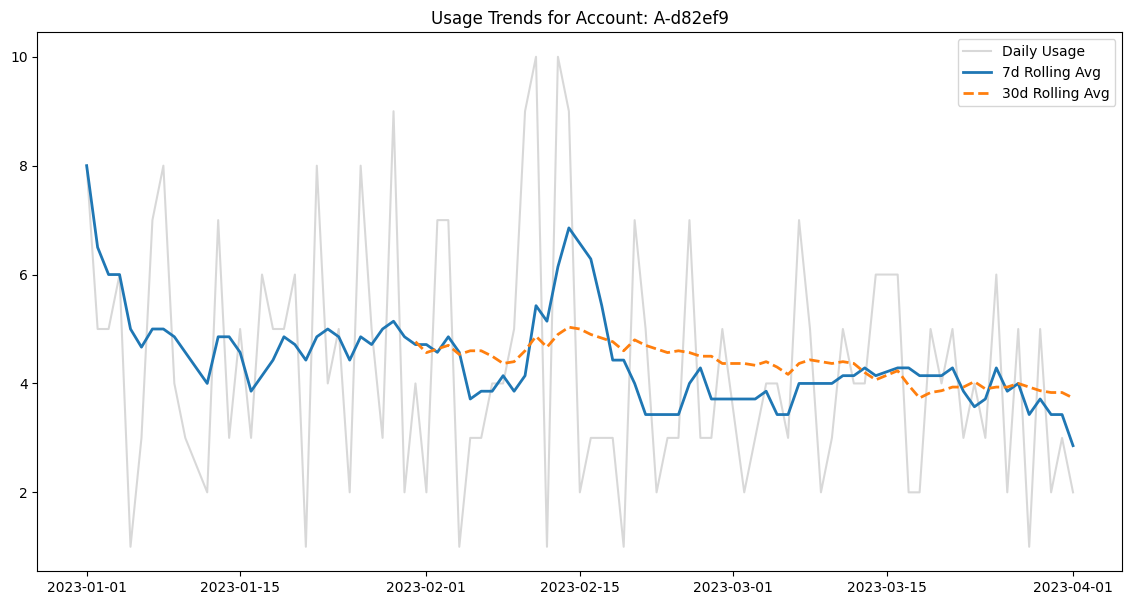

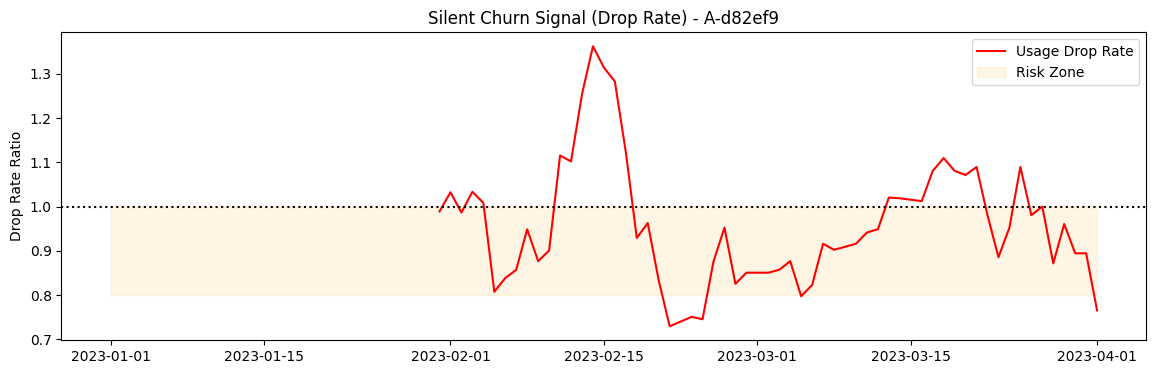

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import text
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from src.databases.db_loader import get_engine

#connet and fetch data
engine = get_engine()
query = "SELECT * FROM processed_features WHERE account_id IN ('A-d82ef9', 'A-5790f4' , 'A-3b5cd1','A-9f2731') ORDER BY usage_date"


with engine.connect() as conn:
    df_plot = pd.read_sql(text(query) , conn)


df_plot['usage_date'] = pd.to_datetime(df_plot['usage_date'])

# rolling averages vs raw usage
plt.figure(figsize=(14,7))

acc_id = 'A-d82ef9'
subset = df_plot[df_plot['account_id'] == acc_id]

plt.plot(subset['usage_date'], subset['daily_usage'], label='Daily Usage', alpha=0.3, color='gray')
plt.plot(subset['usage_date'], subset['usage_7d_avg'], label='7d Rolling Avg', linewidth=2)
plt.plot(subset['usage_date'], subset['usage_30d_avg'], label='30d Rolling Avg', linewidth=2, linestyle='--')

plt.title(f"Usage Trends for Account: {acc_id}")
plt.legend()
plt.show()


# the silent signal (drop rate)
plt.figure(figsize=(14, 4))
plt.plot(subset['usage_date'], subset['usage_drop_rate'], color='red', label='Usage Drop Rate')
plt.axhline(y=1.0, color='black', linestyle=':') # Threshold line
plt.fill_between(subset['usage_date'], 0.8, 1.0, alpha=0.1, color='orange', label='Risk Zone')

plt.title(f"Silent Churn Signal (Drop Rate) - {acc_id}")
plt.ylabel("Drop Rate Ratio")
plt.legend()
plt.show()

